In [11]:
import SpatialIO as io
import FirstPass as firstpass
import pgdissroute as pgdissroute
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# Create AOI and Parameters

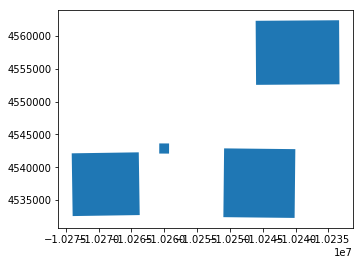

In [12]:
aoiDF = gpd.read_file("../FLW_Missouri Mission Folder/SUPPORT/Staging.shp")
aoiDF = aoiDF.to_crs({'init':'epsg:3857'})
squareDimension = 400
aoiDF.plot()

# Airfield Objective

Generated 12161 squares in 0 seconds


(array([ 123.,  117.,   71.,   21.,   10.,    5.,    7.,    7.,    2.,    1.]),
 array([  775080. ,  1521158.4,  2267236.8,  3013315.2,  3759393.6,
         4505472. ,  5251550.4,  5997628.8,  6743707.2,  7489785.6,
         8235864. ]),
 <a list of 10 Patch objects>)

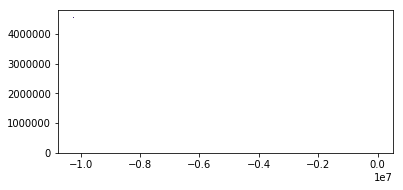

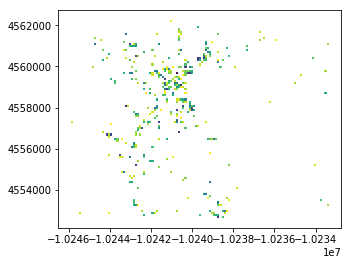

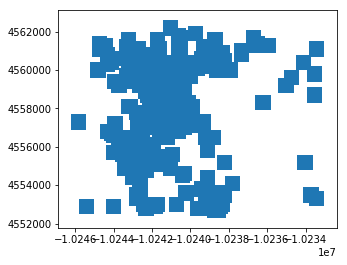

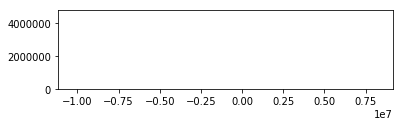

In [13]:
airfieldAOI = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
airfieldEvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(airfieldAOI,100)
slopePath = '../FLW_Missouri Mission Folder/RASTER/slope_proj.tif'
airfieldSlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(airfieldEvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)
airfieldSlopeEvaluationDataFrame.head()
airfieldSlopeEvaluationDataFrame.plot(column='max')
plt.hist(airfieldSlopeEvaluationDataFrame['max'])
airfieldSlopeEvaluationDataFrameSubset = airfieldSlopeEvaluationDataFrame[airfieldSlopeEvaluationDataFrame['max'] < 2]
airfieldSlopeEvaluationDataFrameSubset.head()

len(airfieldSlopeEvaluationDataFrameSubset.index)
airfieldSlopeEvaluationDataFrameSubset.plot(column='max')


largerAirfields = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(airfieldSlopeEvaluationDataFrameSubset, 800)
largerAirfields.head()
largerAirfields.plot()

elevationPath = "../FLW_Missouri Mission Folder/RASTER/DEM_CMB_ELV_SRTMVF2_proj.tif"
largerAirfields.head()
airfieldEvaluationDataFrame.head()

cutFillDF = firstpass.calculateCutFill(largerAirfields,elevationPath,finalElevation='mean',rasterResolution=30)
cutFillDF.head()
cutFillDF.plot(column='totalCutFillVolume')

plt.hist(cutFillDF['totalCutFillVolume'])

# Camp 1 Objective

In [18]:
baseObjective1AOI = aoiDF[aoiDF['Stage']=='Red'].reset_index().geometry[0]
baseObjective1EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective1AOI,100)

Generated 9551 squares in 0 seconds


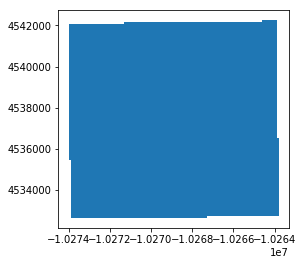

In [19]:
baseObjective1EvaluationDataFrame.plot()

# Camp 2 Objective

In [20]:
baseObjective2AOI = aoiDF[aoiDF['Stage']=='Blue'].reset_index().geometry[0]
baseObjective2EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective2AOI,100)

Generated 11141 squares in 0 seconds


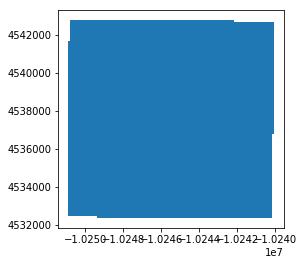

In [21]:
baseObjective2EvaluationDataFrame.plot()